In [1]:
import numpy as np
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionDiffEditPipeline, DDIMScheduler, DDIMInverseScheduler

/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

In [22]:
img_url = "https://github.com/Xiang-cd/DiffEdit-stable-diffusion/raw/main/assets/origin.png"

init_image = download_image(img_url).resize((768, 768))

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
).to(device)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()

mask_prompt = "A bowl of fruits"
prompt = "A bowl of pears"

mask_image = pipeline.generate_mask(image=init_image, source_prompt=prompt, target_prompt=mask_prompt)
image_latents = pipeline.invert(image=init_image, prompt=mask_prompt).latents
edited_image = pipeline(prompt=prompt, mask_image=mask_image, image_latents=image_latents).images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

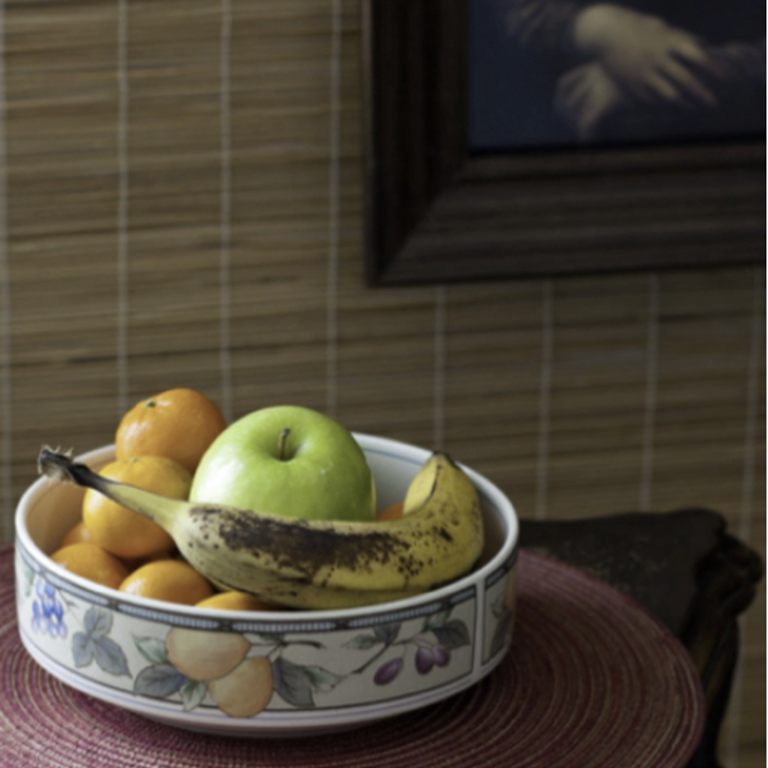

In [23]:
init_image

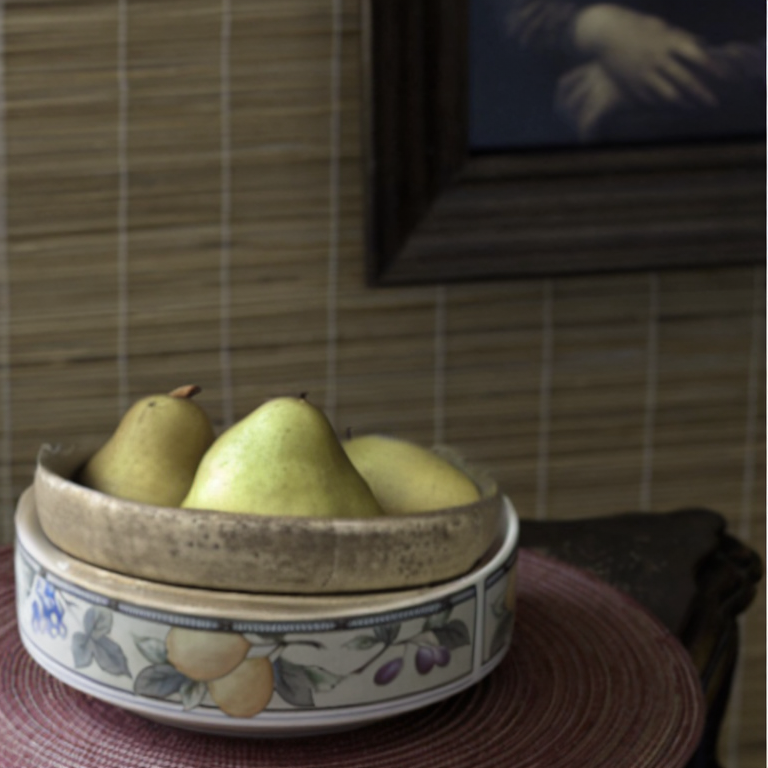

In [24]:
edited_image